Installing the requirements.

In [ ]:
!pip install numpy==1.19.3
!pip install mediapipe
!pip install opencv-python
!pip install matplotlib
!pip install natsorted
!pip install pandas
!pip install plotly
!pip install seaborn

Setting up automatic reload for the scripts that will be written outside the jupyter notebook.

In [ ]:
%load_ext autoreload
%autoreload 2

Importing all dependencies.

In [ ]:
from base64 import b64encode
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from natsort import natsorted
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
%matplotlib inline
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import HTML, display
import ipywidgets as widgets
from typing import List # I don't think I need this!

# Custom imports
from pose_tracking_utils import *

Setting up all the necessary variables.

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

VIDEO_PATH = "./videos/clip_training_session_2.mp4"

Now we create the pose tracking video to visualize the joints and connections.

Compress the video and visualize it on jupyter notebook.

In [ ]:
# For webcam input:
output_path = create_pose_tracking_video(VIDEO_PATH)
#compressed_path = save_compressed_video(output_path)
compressed_path = save_compressed_video(output_path)
# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Create the landmark 3D plot animation.

In [ ]:
anim_output_path = f"./{VIDEO_PATH[:-4]}_anim_landmarks3D.mp4"
create_landmarks_plot3D_animation(VIDEO_PATH, anim_output_path)

compressed_path = save_compressed_video(anim_output_path)
# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

The pose landmarks are this:

Another list of pose landmarks in world coordinates. Each landmark consists of the following:

x, y and z: Real-world 3D coordinates in meters with the origin at the center between hips.
visibility: Identical to that defined in the corresponding

[source](https://google.github.io/mediapipe/solutions/pose.html)

Create the reference plot against which we will set objectives to improve
the desired movements. Like for example I am using olympiam judokas
as my reference to improve my uchimata movement.

(*This function and the interactive widget are not finished*)

In [ ]:
pose_coords = get_pose_coords(video_path=VIDEO_PATH)
# remove all nones from a list
pose_coords = [x for x in pose_coords if x is not None]
print("Length of the list with the pose coordinates: ",len(pose_coords))

Now let's plot the x,y,z coordinates separately in time: 

In [ ]:
right_foot_coords = [pose_coords[i].landmark[31] for i in range(len(pose_coords))]
# Extract x, y, z coordinates from right and right foot
x_coords = [coord.x for coord in right_foot_coords]
y_coords = [coord.y for coord in right_foot_coords]
z_coords = [coord.z for coord in right_foot_coords]


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Foot Movement Over Time')
ax.scatter(x_coords, y_coords, z_coords);

In [ ]:
# Create 3 separate plots showing each coordinates in time
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(x_coords)
axs[0].set_title('X Coordinate')
axs[1].plot(y_coords)
axs[1].set_title('Y Coordinate')
axs[2].plot(z_coords)
axs[2].set_title('Z Coordinate')
plt.tight_layout();

Here we create a 3D plot animation for body parts (in this case for the feet).

In [ ]:
# x_coords = [coord.x for coord in left_foot_coords]
# y_coords = [coord.y for coord in left_foot_coords]
# z_coords = [coord.z for coord in left_foot_coords]

# x_coords_right = [coord.x for coord in right_foot_coords]
# y_coords_right = [coord.y for coord in right_foot_coords]
# z_coords_right = [coord.z for coord in right_foot_coords]

# # Create a 3D scatter plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Foot Movement Over Time')

# def update(frame):
#     ax.clear()
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.set_title('Foot Movement Over Time')
#     ax.scatter(x_coords[:frame], y_coords[:frame], z_coords[:frame])
#     ax.scatter(x_coords_right[:frame], y_coords_right[:frame], z_coords_right[:frame])

# ani = FuncAnimation(fig, update, frames=len(x_coords), interval=5)
# ani.save('animation.mp4', writer='ffmpeg', fps=30)
# #plt.show()

Nicer looking landdmark plot of specific moments of the video, using plotly.

In [ ]:
# Getting the pose coordinates
[pose_coords[i].landmark[0].y for i in range(len(pose_coords))]
#plot_landmarks(pose_coords[200].pose_landmarks,  mp_pose.POSE_CONNECTIONS)

In [ ]:
# Creating a trace visualization
VIDEO_PATH = "./videos/uchimata_wall.mp4"
create_joint_trace(VIDEO_PATH,31, color_rgb=(0,255,0))

In [ ]:
print(VIDEO_PATH)
create_joint_trace_video(VIDEO_PATH,31, color_rgb=(255,0,0))

Realtime updating line plot of the x,y,z coordinates of the body parts.

In [ ]:
# Initialize MediaPipe Pose model
body_part_index = 32
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Initialize OpenCV VideoCapture object to capture video from the camera
cap = cv2.VideoCapture(VIDEO_PATH)

# Create an empty list to store the trace of the right elbow
trace = []

# Create empty lists to store the x, y, z coordinates of the right elbow
x_vals = []
y_vals = []
z_vals = []

# Create a Matplotlib figure and subplot for the real-time updating plot
# fig, ax = plt.subplots()
# plt.title('Time Lapse of the X Coordinate')
# plt.xlabel('Frames')
# plt.ylabel('Coordinate Value')
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.ion()
# plt.show()
frame_num = 0

while True:
    # Read a frame from the video capture
    success, image = cap.read()
    if not success:
        break
    # Convert the frame to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process the frame with MediaPipe Pose model
    results = pose.process(image)

    # Check if any body parts are detected
    
    if results.pose_landmarks:
        # Get the x,y,z coordinates of the right elbow
        x, y, z = results.pose_landmarks.landmark[body_part_index].x, results.pose_landmarks.landmark[body_part_index].y, results.pose_landmarks.landmark[body_part_index].z
        
        # Append the x, y, z values to the corresponding lists
        #x_vals.append(x)
        y_vals.append(y)
        #z_vals.append(z)
        
        # # Add the (x, y) coordinates to the trace list
        trace.append((int(x * image.shape[1]), int(y * image.shape[0])))

        # Draw the trace on the image
        for i in range(len(trace)-1):
            cv2.line(image, trace[i], trace[i+1], (255, 0, 0), thickness=2)

        plt.title('Time Lapse of the Y Coordinate')
        plt.xlabel('Frames')
        plt.ylabel('Coordinate Value')
        plt.xlim(0,len(pose_coords))
        plt.ylim(0,1)
        plt.plot(y_vals);
        # Clear the plot and update with the new x, y, z coordinate values
        #ax.clear()
        # ax.plot(range(0, frame_num + 1), x_vals, 'r.', label='x')
        # ax.plot(range(0, frame_num + 1), y_vals, 'g.', label='y')
        # ax.plot(range(0, frame_num + 1), z_vals, 'b.', label='z')
        # ax.legend(loc='upper left')
        # plt.draw()
        plt.pause(0.00000000001)
        clear_output(wait=True)
        frame_num += 1
    
    # Convert the image back to BGR format for display
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Display the image
    cv2.imshow('Pose Tracking', image)

    # Wait for user input to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    

# Release the video capture, close all windows, and clear the plot
cap.release()
cv2.destroyAllWindows()
plt.close()

In [ ]:
create_landmarks_plot3D_animation("videos/clip_training_session_2.mp4", 
                                  "videos/clip_training_session_2_landmarks3D.mp4")

In [ ]:
def create_joint_trace_graph(video_path, output_path, body_part_index,xmin=300,xmax=1000,
                             ymin=200,ymax=800):
    """
    Creates a graph with the tracing of a particular body part,
    while executing a certain movement.
    """
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    # Create an empty list to store the trace of the body part being tracked
    trace = []
    i = 0
    with mp_pose.Pose(min_detection_confidence=0.5,
                    min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Ignoring empty camera frame.")
                break

            # Convert the frame to RGB format
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Process the frame with MediaPipe Pose model
            results = pose.process(image)

            # Check if any body parts are detected
            if results.pose_landmarks:
                # Get the x,y coordinates of the body part being tracked (in this case, the right elbow)
                x, y = int(results.pose_landmarks.landmark[body_part_index].x * image.shape[1]), int(results.pose_landmarks.landmark[body_part_index].y * image.shape[0])

                # Add the coordinates to the trace list
                trace.append((x, y))

                # Plot the trace on the graph
                fig, ax = plt.subplots()
                #ax.imshow(image)
                # ax.set_xlim(xmin,xmax)
                # ax.set_ylim(ymin,ymax)
                ax.invert_yaxis()
                ax.plot(np.array(trace)[:, 0], np.array(trace)[:, 1], color='r')
                plt.savefig(f'joint_trace{i}.png')
                plt.close()
                i+=1
                #plt.pause(0.00000000001)
                #clear_output(wait=True)
                # Display the graph
                #plt.show()
            
            if cv2.waitKey(5) & 0xFF == 27:
                break
        
        cap.release()
        print("Joint Trace graph created!")
        print("Creating animation")
        create_animation_from_png(".", output_path)


video_path = "./videos/uchimata_wall.mp4"
output_path = f"{video_path[:-4]}_trace.mp4"
body_part_index = 32
create_joint_trace_graph(video_path, output_path, body_part_index)

In [ ]:
# compressed_path = save_compressed_video(output_path)
# # Show video
# mp4 = open(compressed_path,'rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML("""
# <video width=400 controls>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)

In [ ]:
video_path = "./videos/clip_training_session_2.mp4"
body_part_index = 31
foot_trace = get_joint_trace_data(video_path, body_part_index)

In [6]:
video_path = "./videos/uchimata_wall.mp4"
body_part_index = 31
foot_trace_reference = get_joint_trace_data(video_path, body_part_index,xmin=0,ymin=0,xmax=1300)

Ignoring empty camera frame.


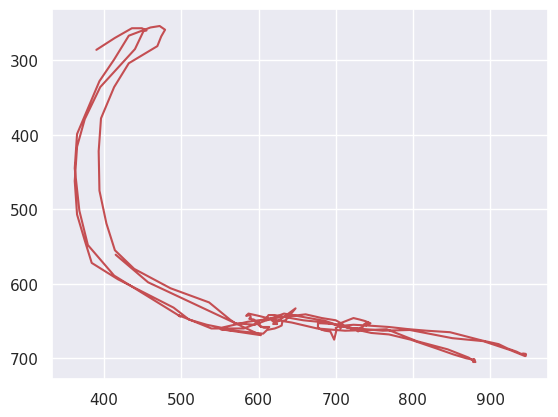

In [7]:
foot_trace_clip = foot_trace[:len(foot_trace_reference)]
plt.plot(np.array(foot_trace_clip)[:, 0], np.array(foot_trace_clip)[:, 1], color='r')
plt.gca().invert_yaxis();

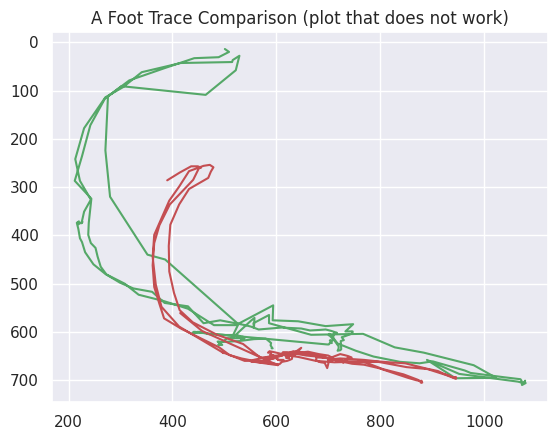

In [8]:
plt.plot(np.array(foot_trace_reference)[:, 0], np.array(foot_trace_reference)[:, 1], color='g')
plt.plot(np.array(foot_trace_clip)[:, 0], np.array(foot_trace_clip)[:, 1], color='r')
plt.title("A Foot Trace Comparison (plot that does not work)")
plt.gca().invert_yaxis();

In [9]:
# x_foot_trace = [f[0] for f in foot_trace]
# x_foot_trace_ref = [f[0] for f in foot_trace_reference]
#dynamic_time_warping(np.array(foot_trace), np.array(foot_trace_reference))
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

max_x = max(max(foot_trace_clip, key=lambda x: x[0])[0], max(foot_trace_reference, key=lambda x: x[0])[0])
max_y = max(max(foot_trace_clip, key=lambda x: x[1])[1], max(foot_trace_reference, key=lambda x: x[1])[1])

foot_trace_clip_norm = [(x/max_x, y/max_y) for (x, y) in foot_trace_clip]
foot_trace_reference_norm = [(x/max_x, y/max_y) for (x, y) in foot_trace_reference]

distance, path = fastdtw(foot_trace_clip_norm, foot_trace_reference_norm, dist=euclidean)
print(distance)
print(path)

34.12849088522559
[(0, 0), (1, 1), (2, 2), (2, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 10), (9, 11), (10, 12), (10, 13), (10, 14), (11, 15), (11, 16), (11, 17), (12, 18), (12, 19), (13, 20), (14, 21), (15, 22), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 39), (35, 39), (36, 39), (37, 39), (38, 40), (39, 41), (40, 42), (41, 43), (42, 44), (43, 45), (44, 46), (45, 47), (46, 48), (47, 49), (48, 50), (49, 51), (50, 52), (51, 52), (52, 53), (53, 54), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (60, 57), (61, 58), (62, 59), (63, 60), (64, 61), (65, 62), (66, 63), (67, 64), (68, 65), (69, 66), (70, 67), (71, 68), (72, 69), (73, 70), (74, 71), (75, 72), (76, 73), (77, 73), (78, 74), (79, 75), (80, 75), (81, 75), (82, 75), (83, 76), (84, 77), (85, 78), (86, 79), (87, 79), (88, 79), (89, 79), (90, 79), (91, 79), (92, 79), (93

Let's plot the values from both sequences that match the values that were mapped and stored into the 
`path` variable:

In [10]:
foot_trace_reference_norm_mapped = [foot_trace_reference_norm[path[i][1]] for i in range(len(path))]
foot_trace_clip_norm_mapped = [foot_trace_clip_norm[path[i][1]] for i in range(len(path))]
foot_trace_reference_norm_mapped[:5]

[(0.4638888888888889, 0.01971830985915493),
 (0.47129629629629627, 0.028169014084507043),
 (0.4527777777777778, 0.04366197183098591),
 (0.40925925925925927, 0.04647887323943662),
 (0.35555555555555557, 0.07605633802816901)]

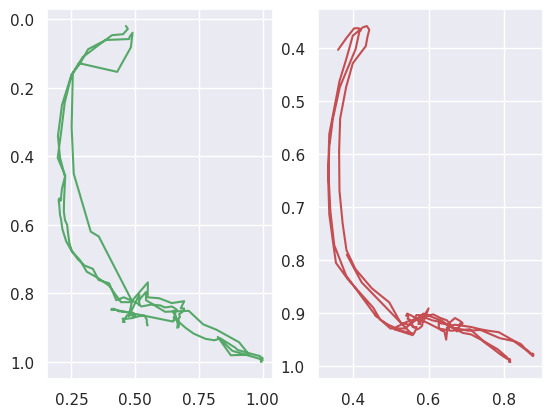

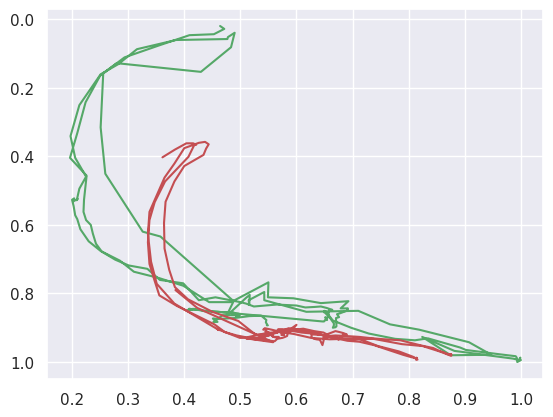

In [11]:
plt.subplot(1,2,1)
plt.plot(np.array(foot_trace_reference_norm_mapped)[:, 0], np.array(foot_trace_reference_norm_mapped)[:, 1], color='g')
plt.gca().invert_yaxis();

plt.subplot(1,2,2)
plt.plot(np.array(foot_trace_clip_norm_mapped)[:, 0], np.array(foot_trace_clip_norm_mapped)[:, 1], color='r')
plt.gca().invert_yaxis();
plt.show()

plt.plot(np.array(foot_trace_reference_norm_mapped)[:, 0], np.array(foot_trace_reference_norm_mapped)[:, 1], color='g')
plt.plot(np.array(foot_trace_clip_norm_mapped)[:, 0], np.array(foot_trace_clip_norm_mapped)[:, 1], color='r');
plt.gca().invert_yaxis();

Get the average trace for each set of movements:

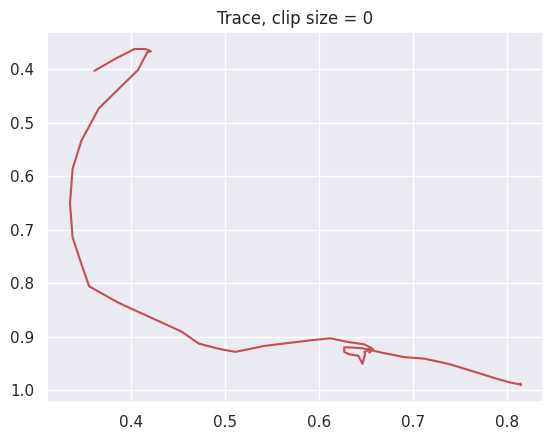

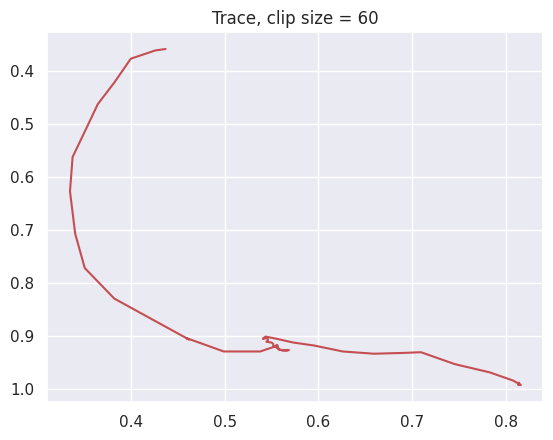

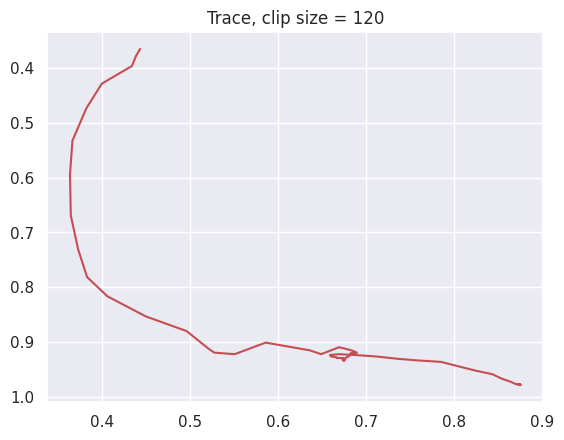

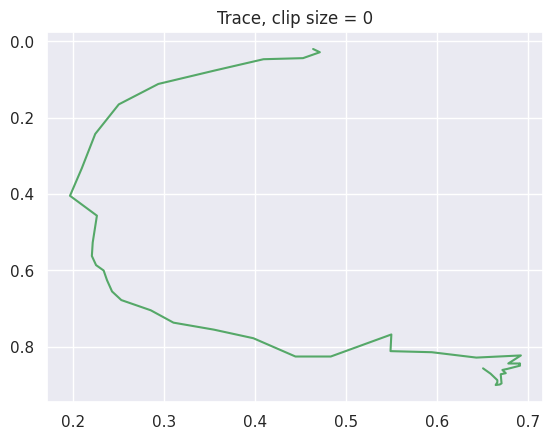

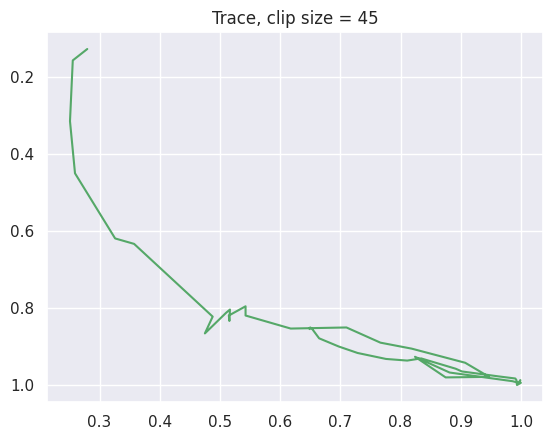

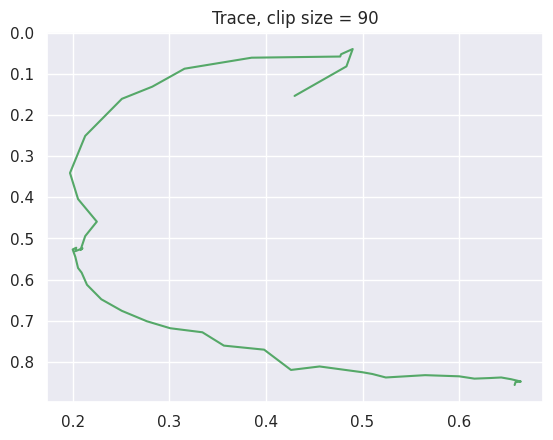

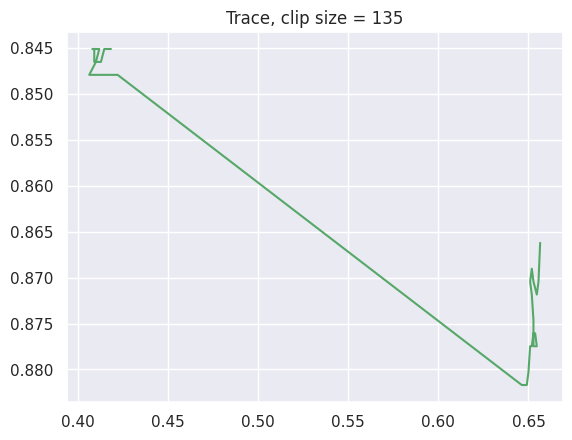

In [13]:
from pose_tracking_utils import *

find_individual_traces(foot_trace_clip_norm)
find_individual_traces(foot_trace_reference_norm, window_size=45,color_plot="g")

In [51]:
traces = get_individual_traces(foot_trace_clip_norm, clip_size=60)
traces_ref = get_individual_traces(foot_trace_reference_norm, clip_size=60)

A few ideas from ChatGPT on how to compare trackings obtained with pose tracking: